# Count Cars in Aerial Imagery Using Deep Learning
> - 🔬 Data Science
> - 🥠 Deep Learning and Object Detection

## Table of Contents
* [Introduction](#Introduction)
* [Necessary imports](#Necessary-imports)
* [Connect to your GIS](#Connect-to-your-GIS)
* [Get data and model for analysis](#Get-data-and-model-for-analysis)
* [Detect and count cars using ArcGIS API for Python](#Detect-and-count-cars-using-ArcGIS-API-for-Python)
* [Visualize detections on map](#Visualize-detections-on-map)
* [Conclusion](#Conclusion)
* [References](#References)

## Introduction 

ArcGIS provides [pretrained deep learning models 🧠](https://livingatlas.arcgis.com/en/browse/?q=dlpk#q=dlpk&d=2) that streamline the process of extracting geographic features from imagery and point cloud datasets. Tasks like manually digitizing vehicles from aerial imagery are often time-consuming and labor-intensive. Deep learning significantly reduces the need for manual work by automating feature extraction.

However, building deep learning models from scratch typically requires substantial data, computational power 🖥️, and expertise. With ArcGIS pretrained models, these challenges are eliminated. These models are trained on diverse datasets across various geographies 🌎. They are accessible through the `ArcGIS Living Atlas of the World` for users with an `ArcGIS Online` account.

One such model, 🚘 [Car Detection-USA](https://doc.arcgis.com/en/pretrained-models/latest/imagery/introduction-to-car-detection-usa.htm), is designed to identify cars in high-resolution aerial or drone imagery. This capability supports applications like traffic and parking analysis, urban planning, and economic indicator monitoring. 🚘 Car detection can even serve as a proxy for estimating retail activity or economic trends. The high spatial and temporal resolution of aerial and drone imagery makes it ideal for such analyses.

### 🎯 Objective

The objective of this notebook is to automatically detect and count cars in aerial or drone imagery using deep learning.

### 📚 What You'll Learn

By the end of this notebook, you will learn how to:
- ✅ Use a pretrained deep learning model from the `ArcGIS Living Atlas`.
- ✅ Apply the model to aerial imagery for object detection using `detect_objects`.
- ✅ Automatically detect and count cars within multiple aerial imageries.

### 🧰 Tools & Technologies

- [ArcGIS API for Python](https://developers.arcgis.com/python/latest/)
- ArcGIS Living Atlas ([Car Detection - USA model](https://geosaurus.maps.arcgis.com/home/item.html?id=cfc57b507f914d1593f5871bf0d52999))
- Deep Learning & Object Detection
- Jupyter Notebook
- Python Libraries: `arcgis`, `ipywidgets`, `pandas`, etc.

### 📂 Dataset Description

- Imagery Source: OpenAerialMap
- The dataset includes high-resolution aerial images (5 cm spatial resolution) of urban and suburban areas, where vehicles are visible and can be detected using object detection models.

### 🗺️ Workflow Overview

The notebook follows a step-by-step pipeline:

1. **Data Preparation**

- Load aerial imagery sourced from OpenAerialMap.
- Ensure images are in a format compatible with the car detection deep learning model as given in its [item page](https://geosaurus.maps.arcgis.com/home/item.html?id=cfc57b507f914d1593f5871bf0d52999).

2. **Model Loading**

- Access the Car Detection - USA pretrained deep learning model from the ArcGIS Living Atlas.

3. **Inference/Detection**

- Apply the model to aerial images to automatically detect cars using `for` loop.
- Return bounding boxes for each detected vehicle.
      
4. **Counting Cars**

- Count the number of cars detected in each image.

5. **Visualization**

- Overlay detection results (bounding boxes) on the imagery.
- Visually inspect detection accuracy and spatial distribution.
- Visualize the count of cars on the chart.

🚀 Let’s get started by importing required modules and preparing our data!

## Necessary imports

In [1]:
# 📦 ArcGIS API for Python Imports
# -----------------------------

import arcgis                                      # The main ArcGIS API package for working with spatial data, maps, layers, and machine learning models.
from arcgis.gis import GIS                         # Provides the GIS class to connect to an ArcGIS Online or ArcGIS Enterprise portal. You'll use this to authenticate, access content, and manage spatial data.
from arcgis.learn import detect_objects            # Imports the key function for object detection using deep learning models.


# 📊 Data Analysis and Utilities
# -----------------------------

import pandas as pd                                # A powerful data analysis library used for tabular data, like storing and analyzing car detection results.
from datetime import datetime as dt                # Used for timestamping output names (e.g., when saving detected layers) or working with date/time operations.
import time                                        # Time-related functions (e.g., sleep, performance timing).

# 🧰 Interactive Widgets for Notebooks
# -----------------------------

from ipywidgets import HBox, VBox, Label, Layout   # Imports layout widgets to organize UI components in Jupyter notebooks. HBox/VBox: layout containers for horizontal/vertical stacking. Label: adds text labels. Layout: helps control the size, padding, and flex behavior of widgets
from IPython.display import display                # Utility to render widgets, maps, images, or HTML content in Jupyter notebook cells.

# 📈 Visualization
# -----------------------------

import plotly.express as px                        # Imports Plotly Express for creating interactive and beautiful charts. We'll use this to create a bar chart showing car counts from the model outputs.

## Connect to your GIS

In [2]:
# Connect to your active ArcGIS session
# -----------------------------
gis = GIS("home")

# Verify connection by printing your username
# -----------------------------
print(f"Connected to ArcGIS as: {gis.users.me.username}")

Connected to ArcGIS as: gis_python


## Get data and model for analysis

🔍 Search for Imagery and Load Model for Car Detection

To begin our analysis, we first need to access the imagery and the pretrained deep learning model. In this case:

- Imagery Source: We’ve downloaded high-resolution aerial imagery from [OpenAerialMap](https://openaerialmap.org/) and published it as a `tiled imagery layer` on `ArcGIS Online`.
- Model: We’ll use the `Car Detection - USA` pretrained model from `ArcGIS Living Atlas`.
- Item Access: Both the imagery and model are accessed using their Item IDs from `ArcGIS Online`.

We also enable searching outside our organization by setting `outside_org=True`.

📥 Load Multiple Imagery Layers Using Item IDs

We’re using three aerial imagery layers for our analysis. These layers can be accessed using their Item IDs via the `gis.content.get()` method.

Once we retrieve the items, we create a list to process them in a loop—useful for tasks like batch object detection.

### Get input imagery

✅ Loaded 7 imagery items.



<Item title:"car_image_1" type:Tiled Imagery Layer owner:api_data_owner>
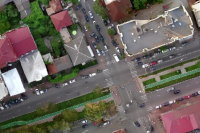

In [3]:
# 📌 Define the list of ArcGIS item IDs for your imagery layers
imagery_item_ids = [
    '18fa4d0c05714cf09e49dd556d71a6f9',   # Site 1
    'b20ca3e1b2314099b4e821f326a4e47f',   # Site 2
    '32f9d5097efa41d7b290b961c33ed285',   # Site 3
    '0d13f1e5735341b182ae5cb4a7b9f376',   # Site 4
    '843297c9ecde4831bbb024bf5d467aac',   # Site 5
    '8c90989c0a704773a1276c99a4fb2d85',   # Site 6
    'cf006ffec19a4deeaf3f7c867e113ac7'    # Site 7
]

# 🔁 Use list comprehension to fetch each imagery item from ArcGIS Online
imagery_list = [gis.content.get(item_id) for item_id in imagery_item_ids]

# ✅ Confirm how many items were successfully loaded
print(f"✅ Loaded {len(imagery_list)} imagery items.\n")

# 🔍 Display the metadata of the first imagery item to verify successful loading
imagery_list[0]

### Visualize loaded imagery

🖼️ Displaying previews of first 2 imagery layers:

📍 Site 1: car_image_1


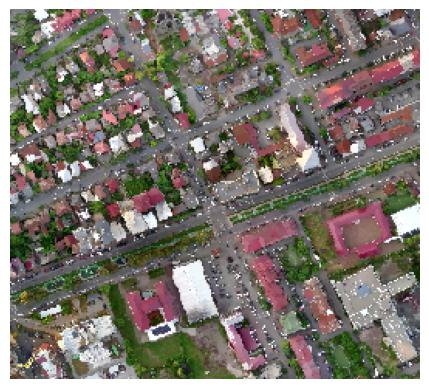

🧾 Item ID: 18fa4d0c05714cf09e49dd556d71a6f9

📍 Site 2: car_image_2


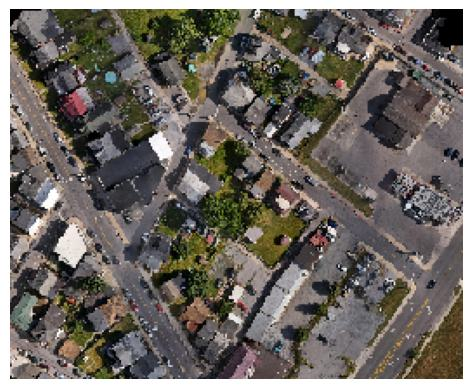

🧾 Item ID: b20ca3e1b2314099b4e821f326a4e47f



In [4]:
print("🖼️ Displaying previews of first 2 imagery layers:\n")

# 🔁 Loop through each imagery item in the list with index and item
for i, item in enumerate(imagery_list[:2], start=1):
    try:
        # ✅ Visualize the imagery using the layers attribute. Access the first layer of the imagery service item
        layer = item.layers[0]  
        
        # 🏷️ Print the site number and its title for clarity
        print(f"📍 Site {i}: {item.title}")
        
        # 🖼️ Display the imagery layer inline (Jupyter auto-renders it)
        display(layer)
        
        # 🧾 Optionally, print the item ID for reference or future use
        print(f"🧾 Item ID: {item.id}\n")
    
    except Exception as e:
        # ⚠️ Catch and report any error (e.g. if item is None or has no layers)
        # Use safe fallback if title is missing
        title = item.title if item and hasattr(item, 'title') else 'Unknown'
        print(f"⚠️ Could not display Site {i}: {title} — {e}")

🔍 Search for the "Car Detection-USA" deep learning model in `ArcGIS Living Atlas`
- The search string includes the `model name` and the `owner` (esri_analytics)
- The item type is restricted to `Deep Learning Package`
- `outside_org=True` allows searching public content outside your org

### Get pretrained deep learning model

<Item title:"Car Detection - USA" type:Deep Learning Package owner:esri_analytics>
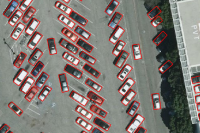

In [5]:
# 📌 Define the search parameters
search_string = "Car Detection-USA owner:esri_analytics"      # Model name + trusted publisher
item_type = "Deep Learning Package"                           # Restrict search to DLPK items

# 🔍 Search ArcGIS Online (including content outside your organization)
model = gis.content.search(query = search_string, item_type = item_type, outside_org = True)[0]  # Get the first result from the list

# ✅ Display the retrieved model item to confirm it loaded correctly
model

## Detect and count cars using ArcGIS API for Python

This code loops through a list of imagery items, uses a pretrained deep learning model to detect cars, and records:

- How many cars were detected per image
- How long the detection took

It uses `ArcGIS API for Python` and its deep learning tools (`detect_objects`), running in a GPU-enabled environment.

In [6]:
# Initialize an empty dictionary to store car counts per imagery

num_cars = {}

Create a for loop to iterate through each imagery.

In [7]:
# Loop over each imagery item by index using enumerate
# ----------------------------------------------------------------

for i, imagery in enumerate(imagery_list):

    try:
        # Access the first raster layer of the current imagery
        raster = imagery.layers[0]
    
        # Record the start time to measure processing duration
        start_time = time.time()

        # Print beginning message 
        print(f"[{i}] Beginning to detect cars in '{imagery.title}'.")
        
        # Run car detection on the raster using the pretrained model
        detected_cars = detect_objects(
            input_raster=raster,                                           # Imagery to analyze
            model=model,                                                   # Pretrained deep learning model
            output_name="detected_cars_" + str(dt.now().microsecond),      # Unique output name for each result
            model_arguments={
                "padding": "100",                                          # Context padding around tiles
                "batch_size": "16",                                        # Batch size (adjust based on hardware)
                "threshold": "0.9",                                        # Confidence threshold for detections
                "return_bboxes": "False",                                  # Return full geometry instead of just bounding boxes
                "tile_size": "224",                                        # Tile size for tile-based processing
            },
            context={
                "processorType": "GPU"                                     # Use GPU for faster processing (if available)
            }
        )
    
        # Record the end time after processing is complete
        end_time = time.time()
        
        # Calculate the duration in minutes
        duration_minutes = (end_time - start_time) / 60
    
        # Print completion message with duration info
        print(f"[{i}] Finished detecting cars in '{imagery.title}' - Duration: {duration_minutes:.2f} minutes")
        
        # Convert detection results to a DataFrame and count the number of detections. detected_cars.query(as_df=True) converts detections to a DataFrame for easy counting.
        num_cars[imagery.name] = len(detected_cars.query(as_df=True))

    except Exception as e:
        # Handle any errors during processing and print a helpful message
        print(f"[{i}] Failed to process '{imagery.title}': {e}")

[0] Beginning to detect cars in 'car_image_1'.
[0] Finished detecting cars in 'car_image_1' - Duration: 84.88 minutes
[1] Beginning to detect cars in 'car_image_2'.
[1] Finished detecting cars in 'car_image_2' - Duration: 17.93 minutes
[2] Beginning to detect cars in 'cars_image_3'.
[2] Finished detecting cars in 'cars_image_3' - Duration: 194.90 minutes
[3] Beginning to detect cars in 'car_image_4e'.
[3] Finished detecting cars in 'car_image_4e' - Duration: 70.25 minutes
[4] Beginning to detect cars in 'car_image_5e'.
[4] Finished detecting cars in 'car_image_5e' - Duration: 33.48 minutes
[5] Beginning to detect cars in 'car_image_6e'.
[5] Finished detecting cars in 'car_image_6e' - Duration: 95.63 minutes
[6] Beginning to detect cars in 'car_image_7e'.
[6] Finished detecting cars in 'car_image_7e' - Duration: 91.25 minutes


## Visualize detections on map

Let's visualize the detected cars in one of the aerial images. 

In [8]:
# Create the first map object to display the raw aerial imagery
map_1 = gis.map()

# Add the third imagery layer (index 2) to the first map
map_1.content.add(imagery_list[0])

# Create a second map object to display both imagery and detected cars
map_2 = gis.map()

# Add the same imagery layer to the second map
map_2.content.add(imagery_list[0])

# Add the detected cars feature layer to the second map
map_2.content.add(detected_cars)

- `map1` shows the original aerial imagery without detections.

- `map2` shows the same imagery plus the detected car features overlaid.

- Synchronizing maps (`sync_navigation`) allows you to pan/zoom both maps together for easy comparison.

Lets, sync both the maps...

In [9]:
# Synchronize the navigation of both maps for simultaneous panning and zooming
map_1.sync_navigation(map_2)

Create a layout to visualize both the map objects. Keep running the below cells. Maps will automatically update here.

- Flexbox layout: ensures responsive sizing and neat padding.
- VBox + Label: groups label and map vertically.
- HBox: places both groups side-by-side for easy comparison.
- Display: renders the entire widget structure in the notebook output cell.

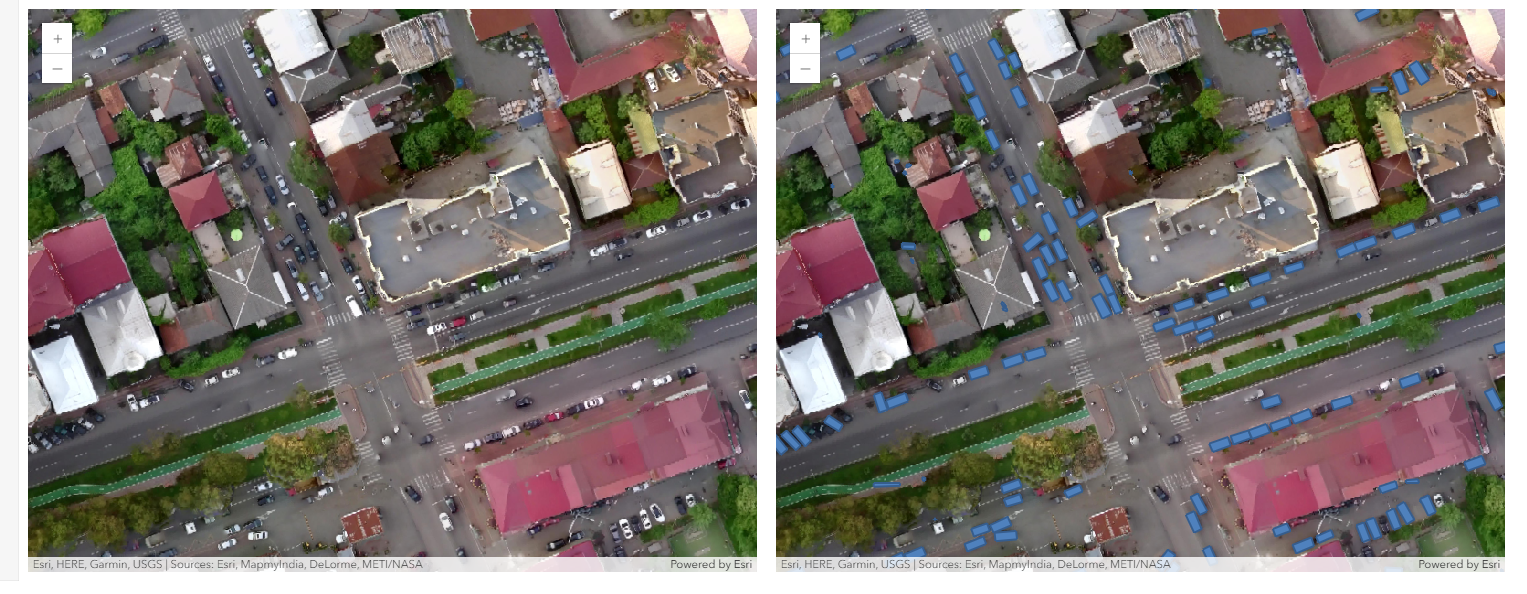

In [10]:
# Configure the layout for each map widget
# ----------------------------------------------------------------
# Use 'flex' to allow the map widgets to grow and shrink responsively.
# '1 1 auto' means: flex-grow=1, flex-shrink=1, flex-basis=auto.
# Padding adds space around each map to avoid a cramped appearance.
map_1.layout = Layout(flex='1 1 auto', padding='10px')
map_2.layout = Layout(flex='1 1 auto', padding='10px')

# Create vertical containers (VBox) for each map + label
# ----------------------------------------------------------------
# VBox stacks widgets vertically.
# Each VBox contains:
#  - A descriptive Label on top
#  - The corresponding map widget below
# Layout width '50%' splits the horizontal space evenly between the two VBoxes.
box1 = VBox(
    [Label("Input Imagery"), map_1],  # Label above map1
    layout=Layout(width='50%')       # Take half the horizontal space
)

box2 = VBox(
    [Label("Input Imagery with Detected Features"), map_2],  # Label above map2
    layout=Layout(width='50%')                               # Take other half
)

# Arrange both VBoxes side-by-side horizontally using HBox
# ----------------------------------------------------------------
# HBox places widgets side by side horizontally.
# Both boxes appear next to each other, each occupying 50% width.
hbox = HBox([box1, box2])

# Display the combined layout in the notebook
# ----------------------------------------------------------------
# This renders the labeled maps side by side within the notebook.
display(hbox)

Zoom to the extent of detected features using `zoom_to_layer` attribute

In [11]:
# 🔎 Automatically zoom the map to the extent of the detected features
map_1.zoom_to_layer(detected_cars)

Set the extent of the map to your desired extent.

In [12]:
# 🌍 Manually set the map extent (useful for focusing on a fixed area)

map_1.extent = {'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
 'xmin': 4633796.204753878,
 'ymin': 5106390.057390195,
 'xmax': 4634028.501660079,
 'ymax': 5106569.206675184}

Now you must be seeing the added imagery layer and detected features over the map in the desired extent. Use this if you want to focus the map on a specific bounding box (e.g., a city block or parking lot).

Check the count of cars in each imagery by displaying the output of `num_cars` dictionary created in above steps.

In [13]:
num_cars  # shows number of cars detected in each imagery layer.

{'car_image_1': 780,
 'car_image_2': 83,
 'cars_image_3': 610,
 'car_image_4e': 610,
 'car_image_5e': 183,
 'car_image_6e': 29,
 'car_image_7e': 631}

Visualize detections count in chart

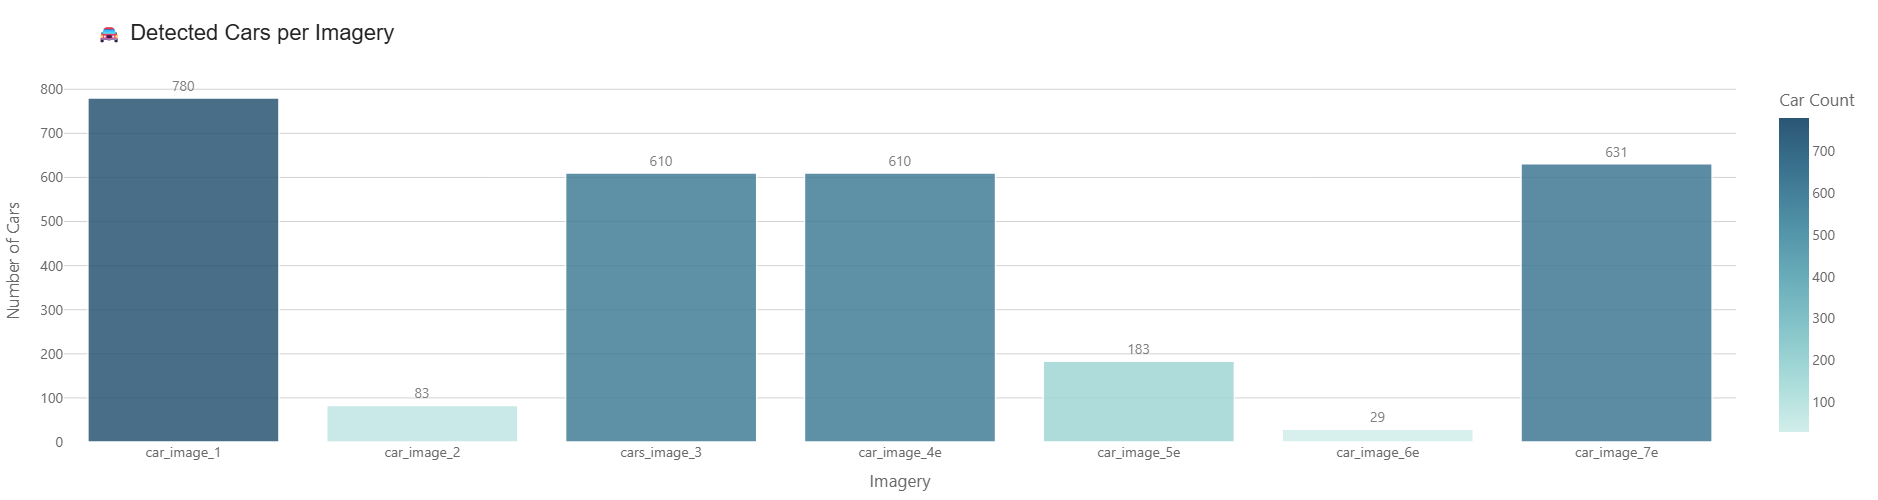

In [14]:
# Convert num_cars dictionary to DataFrame
car_df = pd.DataFrame(list(num_cars.items()), columns=["Imagery", "Car Count"])

# Sort by count (optional, for aesthetic ordering)
# car_df = car_df.sort_values("Car Count", ascending=False)

# Create an interactive bar chart
fig = px.bar(car_df, x="Imagery", y="Car Count", text="Car Count", color="Car Count", color_continuous_scale="teal",  title="🚘 Detected Cars per Imagery")

# Enhance layout for a modern look
fig.update_traces(textposition='outside', marker_line_color='white', marker_line_width=1.5, opacity=0.85)

fig.update_layout(
    title_font=dict(size=22, family='Helvetica', color='#222'),
    font=dict(family='Segoe UI', size=14, color='dimgray'),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='white',
    xaxis_title="Imagery",
    yaxis_title="Number of Cars",
    xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='lightgray'),
    margin=dict(l=40, r=40, t=80, b=40),
    height=500,
    width=1000,
)

# Show the elegant chart
fig.show()

## Conclusion

This notebook demonstrated how to:

- ✅ Use the Car Detection - USA pretrained deep learning model from ArcGIS Living Atlas
- ✅ Apply it to aerial or drone imagery
- ✅ Automatically detect cars
- ✅ And count cars per image for analysis or decision-making.

This workflow can support real-world applications such as:

- 🚗 Traffic monitoring
- 🅿️ Parking lot utilization
- 🏙️ Urban planning
- 📈 Estimating economic activity

## References

- Imagery from [OpenAerialMap](https://openaerialmap.org/) is licensed under [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/)